## 6.7 Практическая работа 

## План ноутбука:

1. Вводные по задаче.

2. Библиотеки.

3. Загрузка и подготовка данных.

4. Блок функций.

5. Модель RNN

6. Модель LSTM

7. Модель GRU

8. Результаты и выводы.

## Вводные по задаче.

Цель практической работы

Научиться решать задачи бинарной классификации текста с использованием архитектур RNN, LSTM и GRU.

Предсказать, является ли статья фейковой, основываясь на её заголовке, URL и веб-домене, на котором она была размещена.

Задача 1

    Загрузите датасет Fake News, выберите для работы столбцы ['title','news_url','source_domain','real'].

    Проверьте наличие null-значений и удалите их, если они есть.

    Проверьте баланс классов.

    Комбинируйте текст из столбцов ['title','news_url','source_domain'] в один столбец ‘text’.

    Определите поля TEXT и LABEL, затем, используя эти переменные, создайте датасет и постройте словари.

    Разделите данные на тестовую и обучающую выборки в соотношении 80 на 20.

    Создайте два итератора: train_iterator и test_iterator.

    Обучите модель w2v для векторизации текста с использованием from gensim.models import Word2Vec:

    Создайте модель RNN с использованием PyTorch.
    
    Оцените работу модели, построив графики accuracy и loss.
    
    Рассчитайте для тестовой выборки следующие метрики: accuracy, f1-score, ROC AUC (постройте для неё график).

Задача 2

Повторите шаги 8–10 для архитектур LSTM и GRU.
Критерии оценки 

Принято: загружен датасет, выполнена предобработка, получены векторы, обучена модель, оценена работа модели, получены все указанные метрики.

Порог RNN:

    Accuracy: 0.23.
    F1 Score: 0.37.
    ROC AUC Score: 0.69.

Порог LSTM:

    Accuracy: 0.23.
    F1 Score: 0.37.
    ROC AUC Score: 0.76.

Порог GRU:

    Accuracy: 0.23.
    F1 Score: 0.37.
    ROC AUC Score: 0.76.

## Библиотеки

In [1]:
import pandas as pd
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import matplotlib.pyplot as plt
import spacy # для токенизации текста будет использоваться библиотека SpaCy
import torchtext.data as data
from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from gensim.models import Word2Vec

/home/leostuchchi/anaconda3/envs/torch/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Загрузка и подготовка данных

In [2]:
df = pd.read_csv(r'data/FakeNewsNet.csv', encoding='utf-8')
df.shape

(23196, 5)

In [3]:
df.columns

Index(['title', 'news_url', 'source_domain', 'tweet_num', 'real'], dtype='object')

In [4]:
df = df[['title','news_url','source_domain','real']]
df.head()

,title,news_url,source_domain,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,1


In [5]:
# Проверяем на наличие null-значений
df.isnull().sum()
print(df.shape)
df.dropna(inplace=True)
df.shape

(23196, 4)


(22866, 4)

In [6]:
df['real'].value_counts()

real
1    17371
0     5495
Name: count, dtype: int64

In [7]:
# Объединение столбцов в новый столбец 'text'
df['text'] = df['title'] + ' | ' + df['news_url'] + ' | ' + df['source_domain']
df.shape

(22866, 5)

In [8]:
# Обучение модели Word2Vec
sentences = [row.split() for row in df['text']]  # Разделяем текст на слова
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [9]:
# Определение полей TEXT и LABEL
TEXT = data.Field(sequential=True, tokenize='spacy', lower=True, tokenizer_language='en_core_web_sm')
LABEL = data.LabelField(dtype=torch.float)

In [10]:
# список примеров
examples = []
for index, row in df.iterrows():
    text = row['text']
    label = row['real']
    examples.append(data.Example.fromlist([text, label], fields=[('text', TEXT), ('label', LABEL)]))

In [11]:
#  Dataset
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [12]:
# seed для воспроизводимости
SEED = 42
random.seed(SEED)

# тренировочный и тестовый наборы данных
train_data, test_data = dataset.split(split_ratio=0.8, random_state=random.seed(SEED))

In [13]:
# Построение словаря
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

In [14]:
# Определение BATCH_SIZE и указание, что при наличии GPU вычисления будут выполняться на нём
BATCH_SIZE = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Использование BucketIterator из библиотеки torchtext позволяет эффективно обрабатывать текстовые данные путем группировки примеров схожей длины в батчи. Это не только минимизирует количество паддинга, но и улучшает производительность модели во время обучения. Понимание работы этого итератора поможет вам более эффективно работать с текстовыми данными в ваших проектах на PyTorch.

In [15]:
# Создаём итератор
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_within_batch=True, # сортировка по длине внутри батча
    sort_key=lambda x: len(x.text))

## Блок функций

In [16]:
# Вычисляем accuracy
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Обучение
def train(model, iterator, optimizer, criterion): # обучение одной эпохи 
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    all_predictions = []
    all_labels = []

    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)
    val_acc = binary_accuracy(all_predictions, all_labels)
    val_loss = criterion(all_predictions, all_labels).item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), val_loss, val_acc.item()


# Вычисление метрик + ROC кривая
def evaluate_model(model, iterator):
    all_predictions = []
    all_labels = []

    for batch in tqdm(iterator):
        predictions = model(batch.text).squeeze(1)
        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    y_pred_binary = torch.round(torch.sigmoid(all_predictions)).cpu().numpy()
    y_true = all_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, all_predictions.cpu().numpy())

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    fpr, tpr, _ = roc_curve(y_true, all_predictions.cpu().numpy())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# metrix
def metrix_model(model, iterator):
    all_predictions = []
    all_labels = []

    for batch in tqdm(iterator):
        predictions = model(batch.text).squeeze(1)
        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    y_pred_binary = torch.round(torch.sigmoid(all_predictions)).cpu().numpy()
    y_true = all_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, all_predictions.cpu().numpy())

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    


## Модель RNN

In [17]:
# Обучение модели Word2Vec
sentences = [row.split() for row in df['text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

После обучения модели Word2Vec мы можем создать эмбеддинги для слов, которые будем использовать в нашей RNN модели. Нам нужно будет создать матрицу эмбеддингов, которая будет использоваться в слое nn.Embedding.

In [18]:
# Параметры модели
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100  # Размер векторов Word2Vec
HIDDEN_DIM = 256     # Скрытый размер RNN
N_LAYERS = 1
OUTPUT_DIM = 1       # Для бинарной классификации
DROPOUT = 0.5

In [19]:
# Создание словаря и матрицы эмбеддингов
embedding_matrix = torch.zeros((len(TEXT.vocab), EMBEDDING_DIM))

for i, word in enumerate(TEXT.vocab.itos):
    if word in w2v_model.wv:
        embedding_vector = w2v_model.wv[word]
        embedding_matrix[i] = torch.tensor(embedding_vector)

вариант 1.
sentences = [row.split() for row in df['text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
embedding_matrix = torch.zeros((len(TEXT.vocab), EMBEDDING_DIM))

for i, word in enumerate(TEXT.vocab.itos):
    if word in w2v_model.wv:
        embedding_vector = w2v_model.wv[word]
        embedding_matrix[i] = torch.tensor(embedding_vector)
вариант 2.
w2v_model = gensim.models.word2vec.Word2Vec(...)
w2v_model.build_vocab(...)
w2v_model.train(...)
w2v_model.save('...txt')
w2v_model = gensim.models.word2vec.Word2Vec.load('...txt')
После этого получите word2vec_vectors и используйте его здесь:
pre_trained_emb = torch.FloatTensor()
embedding = nn.Embedding.from_pretrained()

Вариант 1

python
sentences = [row.split() for row in df['text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
embedding_matrix = torch.zeros((len(TEXT.vocab), EMBEDDING_DIM))

for i, word in enumerate(TEXT.vocab.itos):
    if word in w2v_model.wv:
        embedding_vector = w2v_model.wv[word]
        embedding_matrix[i] = torch.tensor(embedding_vector)

Описание:

    Обучение модели: В этом варианте модель Word2Vec обучается непосредственно на предложениях, полученных из столбца text вашего DataFrame df.
    Создание матрицы эмбеддингов: После обучения модели создается матрица эмбеддингов, где для каждого слова из словаря TEXT.vocab извлекается соответствующий вектор из обученной модели.
    Простота: Этот подход прост и интуитивно понятен, так как все происходит в одном блоке кода.

Вариант 2

python
w2v_model = gensim.models.word2vec.Word2Vec(...)
w2v_model.build_vocab(...)
w2v_model.train(...)
w2v_model.save('...txt')
w2v_model = gensim.models.word2vec.Word2Vec.load('...txt')
pre_trained_emb = torch.FloatTensor()
embedding = nn.Embedding.from_pretrained(pre_trained_emb)

Описание:

    Обучение модели: Здесь модель Word2Vec также обучается на данных, но с явным разделением этапов: сначала создается словарь (build_vocab), затем происходит обучение (train), и после этого модель сохраняется на диск.
    Загрузка модели: После сохранения модель загружается обратно для использования. Это может быть полезно для повторного использования уже обученной модели без необходимости повторного обучения.
    Использование предобученных эмбеддингов: В этом варианте вы можете использовать предобученные эмбеддинги (например, загруженные из внешнего источника) и инициализировать слой nn.Embedding с помощью метода from_pretrained, что позволяет избежать обучения с нуля.

Сравнение
Характеристика	Вариант 1	Вариант 2
Обучение	Обучение происходит в одном блоке	Разделение на этапы: обучение, сохранение, загрузка
Сохранение модели	Не сохраняется на диск	Сохраняется на диск для последующего использования
Гибкость	Менее гибкий (обучение каждый раз заново)	Более гибкий (можно использовать предобученные модели)
Простота использования	Прост в реализации	Чуть более сложный из-за этапов загрузки и сохранения
Как это повлияет на результат?

    Результаты обучения: Оба подхода могут давать схожие результаты при условии, что данные одинаковы. Однако предобученные модели могут дать лучшие результаты на небольших наборах данных или в задачах с недостатком данных.
    Время обучения: Вариант 1 может занять больше времени при каждом запуске, так как модель обучается заново. Вариант 2 позволяет избежать повторного обучения, что экономит время.
    Качество эмбеддингов: Если вы используете предобученные эмбеддинги (в варианте 2), это может значительно улучшить производительность модели на задачах с текстом, особенно если предобученные эмбеддинги были получены на большом и разнообразном корпусе текстов.

Интеграция эмбеддингов в RNN

Теперь мы можем передать embedding_matrix в нашу модель RNN:

In [20]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Преобразование индексов слов в векторы вложений
        self.embedding.weight.data.copy_(embedding_matrix)  # Инициализация весов эмбеддингов
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout)  # Обработка входных вложений
        self.fc = nn.Linear(hidden_dim, output_dim)  # Преобразует скрытое состояние в выходной вектор
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):  # Определение прохождения данных через модель
        embedded = self.dropout(self.embedding(text))  # Преобразование текста в вектор и применение dropout
        output, hidden = self.rnn(embedded)  # Получаем выход и скрытое состояние
        hidden = self.dropout(hidden[-1,:,:])  # Извлекаем последнее скрытое состояние
        return self.fc(hidden.squeeze(0))  # Возвращаем выходной вектор

In [21]:
model_rnn = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).to(device)

/home/leostuchchi/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [22]:
# Инициализация оптимизатора и функции потерь
optimizer = optim.Adam(model_rnn.parameters())
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()  # Используем BCEWithLogitsLoss для бинарной классификации

In [23]:
model_rnn = model_rnn.to(device)
criterion = criterion.to(device)

In [24]:
N_EPOCHS = 3

In [25]:
train_losses_rnn = []
train_accuracies_rnn = []
val_losses_rnn = []
val_accuracies_rnn = []

for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc, val_loss, val_acc = train(model_rnn, train_iterator, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses_rnn.append(train_loss)
    train_accuracies_rnn.append(train_acc)
    val_losses_rnn.append(val_loss)
    val_accuracies_rnn.append(val_acc)


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [01:00<02:00, 60.12s/it]

Epoch: 01, Train Loss: 0.524, Train Acc: 77.66%, Val Loss: 0.524, Val Acc: 77.66%


 67%|██████▋   | 2/3 [02:46<01:27, 87.52s/it]

Epoch: 02, Train Loss: 0.417, Train Acc: 82.78%, Val Loss: 0.416, Val Acc: 82.78%


100%|██████████| 3/3 [05:21<00:00, 107.20s/it]

Epoch: 03, Train Loss: 0.139, Train Acc: 94.78%, Val Loss: 0.139, Val Acc: 94.78%


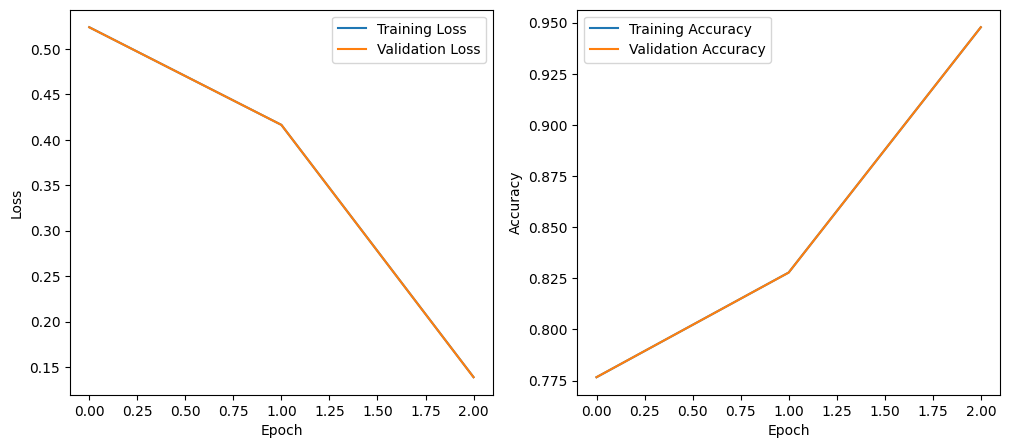

In [26]:
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses_rnn, label='Training Loss')
plt.plot(val_losses_rnn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_rnn, label='Training Accuracy')
plt.plot(val_accuracies_rnn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

100%|██████████| 153/153 [00:01<00:00, 86.23it/s]


Accuracy: 0.8086595232888695
F1 Score: 0.5236799129014698
ROC AUC Score: 0.7796563893687227


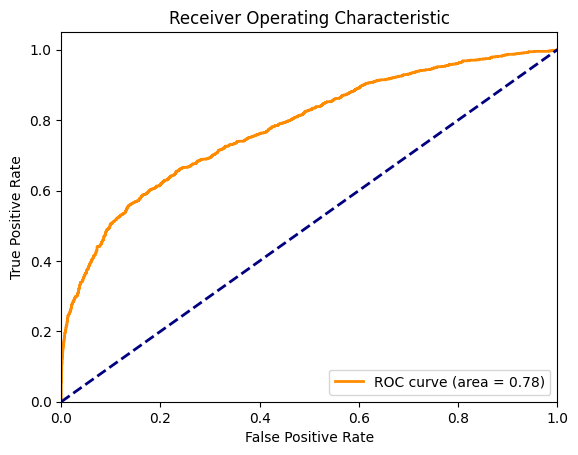

In [27]:
# получение метрик
evaluate_model(model_rnn, test_iterator)

In [56]:
# Сохранение модели
#torch.save(model_rnn.state_dict(), 'model_rnn.pt' )

## Модель LSTM

In [29]:
# Обучение модели Word2Vec
sentences = [row.split() for row in df['text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Параметры модели
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100  # Размер векторов Word2Vec
HIDDEN_DIM = 256     # Скрытый размер RNN
N_LAYERS = 1
OUTPUT_DIM = 1       # Для бинарной классификации
DROPOUT = 0.5

# Создание словаря и матрицы эмбеддингов
embedding_matrix = torch.zeros((len(TEXT.vocab), EMBEDDING_DIM))

for i, word in enumerate(TEXT.vocab.itos):
    if word in w2v_model.wv:
        embedding_vector = w2v_model.wv[word]
        embedding_matrix[i] = torch.tensor(embedding_vector)

In [30]:
# Определяем модель
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # преобразование индексов слов в векторы вложений
        self.embedding.weight.data.copy_(embedding_matrix)  # Инициализация весов эмбеддингов
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = dropout) # обработка входных вложений и выдача скрытых состояний
        self.fc = nn.Linear(hidden_dim, output_dim) # преобразует скрытое состояние в выходной вектор
        self.dropout = nn.Dropout(dropout)

    def forward(self, text): # определение прохождения данных через модель
        embedded = self.dropout(self.embedding(text)) # преобразование текста в вектор и применение dropout
        output, (hidden, cell) = self.rnn(embedded) # 
        hidden = self.dropout(hidden[-1,:,:]) # извлекаем последнее скрытое состояние
        return self.fc(hidden.squeeze(0))

In [31]:
model_lstm = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).to(device)

/home/leostuchchi/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [32]:
# Определяем оптимизатор и функцию потерь
optimizer = optim.Adam(model_lstm.parameters())
criterion = nn.BCEWithLogitsLoss()

In [33]:
model_lstm = model_lstm.to(device)
criterion = criterion.to(device)

In [34]:
N_EPOCHS = 3

In [35]:
train_losses_lstm = []
train_accuracies_lstm = []
val_losses_lstm = []
val_accuracies_lstm = []

for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc, val_loss, val_acc = train(model_lstm, train_iterator, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses_lstm.append(train_loss)
    train_accuracies_lstm.append(train_acc)
    val_losses_lstm.append(val_loss)
    val_accuracies_lstm.append(val_acc)


 33%|███▎      | 1/3 [01:48<03:36, 108.06s/it]

Epoch: 01, Train Loss: 0.488, Train Acc: 79.11%, Val Loss: 0.488, Val Acc: 79.10%


 67%|██████▋   | 2/3 [04:24<02:16, 136.51s/it]

Epoch: 02, Train Loss: 0.234, Train Acc: 91.05%, Val Loss: 0.234, Val Acc: 91.05%


100%|██████████| 3/3 [07:40<00:00, 153.66s/it]

Epoch: 03, Train Loss: 0.005, Train Acc: 99.91%, Val Loss: 0.005, Val Acc: 99.91%


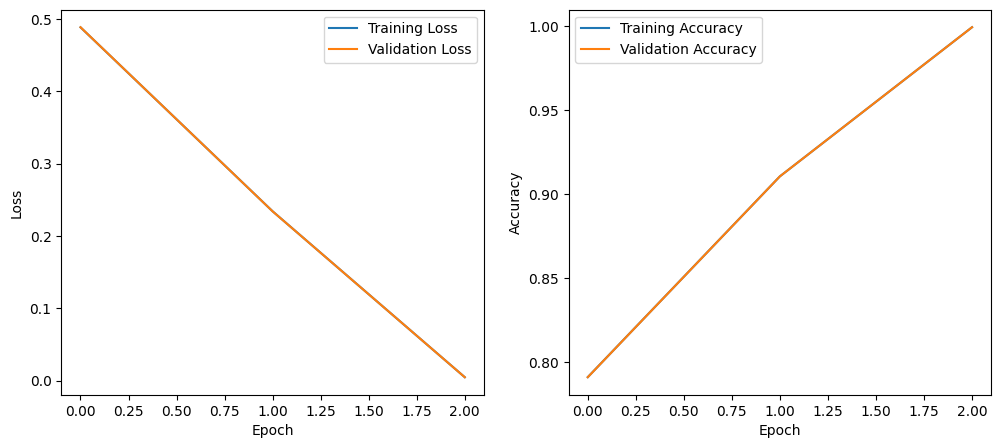

In [36]:
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses_lstm, label='Training Loss')
plt.plot(val_losses_lstm, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_lstm, label='Training Accuracy')
plt.plot(val_accuracies_lstm, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [57]:
# Сохранение модели
#torch.save(model_lstm.state_dict(), 'model_lstm.pt' )

100%|██████████| 153/153 [00:05<00:00, 30.38it/s]


Accuracy: 0.8637655805816751
F1 Score: 0.6350322202694786
ROC AUC Score: 0.8694526069321299


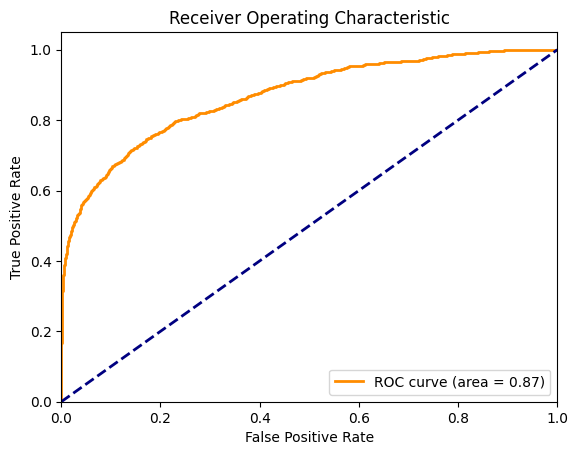

In [38]:
evaluate_model(model_lstm, test_iterator)

## Модель GRU

In [39]:
# Обучение модели Word2Vec
sentences = [row.split() for row in df['text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Параметры модели
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100  # Размер векторов Word2Vec
HIDDEN_DIM = 256     # Скрытый размер RNN
N_LAYERS = 1
OUTPUT_DIM = 1       # Для бинарной классификации
DROPOUT = 0.5

# Создание словаря и матрицы эмбеддингов
embedding_matrix = torch.zeros((len(TEXT.vocab), EMBEDDING_DIM))

for i, word in enumerate(TEXT.vocab.itos):
    if word in w2v_model.wv:
        embedding_vector = w2v_model.wv[word]
        embedding_matrix[i] = torch.tensor(embedding_vector)

In [40]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Преобразование индексов слов в векторы вложений
        self.embedding.weight.data.copy_(embedding_matrix)  # Инициализация весов эмбеддингов
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout)  # Обработка входных вложений и выдача скрытых состояний
        self.fc = nn.Linear(hidden_dim, output_dim)  # Преобразует скрытое состояние в выходной вектор
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):  # Определение прохождения данных через модель
        embedded = self.dropout(self.embedding(text))  # Преобразование текста в вектор и применение dropout
        output, hidden = self.rnn(embedded)  # Получаем выход и скрытое состояние
        hidden = self.dropout(hidden[-1,:,:])  # Извлекаем последнее скрытое состояние
        return self.fc(hidden.squeeze(0))  # Возвращаем выходной вектор

In [41]:
model_gru = GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).to(device)

/home/leostuchchi/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [42]:
# Определяем оптимизатор и функцию потерь
optimizer = optim.Adam(model_gru.parameters())
criterion = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss для стабильности

In [43]:
model_gru = model_gru.to(device)
criterion = criterion.to(device)

In [44]:
N_EPOCHS = 3

In [45]:
train_losses_gru = []
train_accuracies_gru = []
val_losses_gru = []
val_accuracies_gru = []

for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc, val_loss, val_acc = train(model_gru, train_iterator, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses_gru.append(train_loss)
    train_accuracies_gru.append(train_acc)
    val_losses_gru.append(val_loss)
    val_accuracies_gru.append(val_acc)


 33%|███▎      | 1/3 [01:50<03:40, 110.02s/it]

Epoch: 01, Train Loss: 0.452, Train Acc: 80.76%, Val Loss: 0.452, Val Acc: 80.75%


 67%|██████▋   | 2/3 [04:25<02:16, 136.92s/it]

Epoch: 02, Train Loss: 0.164, Train Acc: 93.74%, Val Loss: 0.164, Val Acc: 93.74%


100%|██████████| 3/3 [07:49<00:00, 156.47s/it]

Epoch: 03, Train Loss: 0.004, Train Acc: 99.93%, Val Loss: 0.004, Val Acc: 99.93%


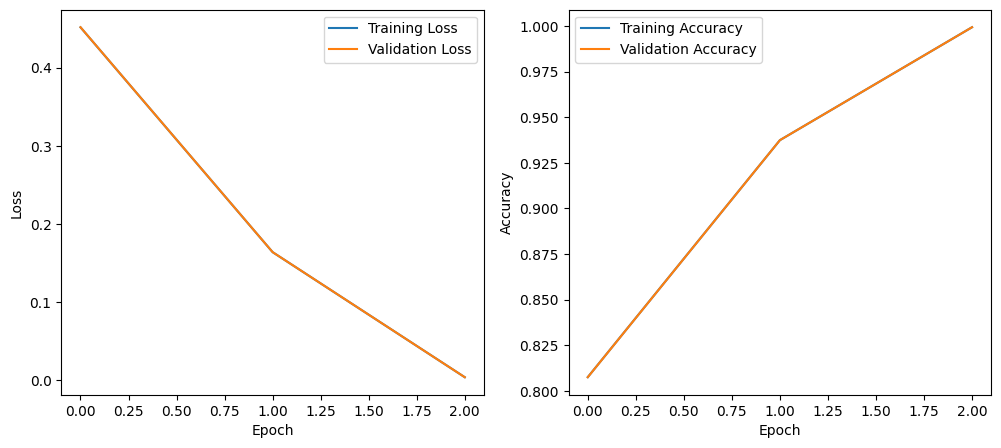

In [46]:
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses_gru, label='Training Loss')
plt.plot(val_losses_gru, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_gru, label='Training Accuracy')
plt.plot(val_accuracies_gru, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

100%|██████████| 153/153 [00:06<00:00, 25.36it/s]


Accuracy: 0.8368685764268533
F1 Score: 0.5989247311827957
ROC AUC Score: 0.824025972646282


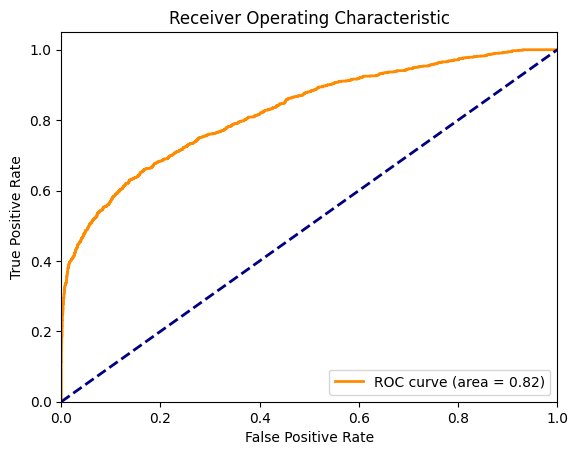

In [47]:
evaluate_model(model_gru, test_iterator)

In [58]:
# Сохранение модели
#torch.save(model_gru.state_dict(), 'model_gru.pt' )

## Результаты и выводы

In [55]:
print('model_RNN')
metrix_model(model_rnn, test_iterator)

model_RNN


100%|██████████| 153/153 [00:01<00:00, 88.57it/s]

Accuracy: 0.8112836212551935
F1 Score: 0.5362708221386352
ROC AUC Score: 0.7844935928898181


In [50]:
print('model_LSTM')
metrix_model(model_lstm, test_iterator)

model_LSTM


100%|██████████| 153/153 [00:07<00:00, 19.17it/s]

Accuracy: 0.8572053356658649
F1 Score: 0.6147492625368731
ROC AUC Score: 0.8644241781030025


In [51]:
print('model_GRU')
metrix_model(model_lstm, test_iterator)

model_GRU


100%|██████████| 153/153 [00:06<00:00, 22.33it/s]

Accuracy: 0.8587360594795539
F1 Score: 0.6213364595545134
ROC AUC Score: 0.8618657428359564


### F1 Score: LSTM и GRU имеют схожие значения F1 Score, которые выше, чем у RNN. Это говорит о том, что они лучше справляются с балансом между точностью и полнотой.
    
### ROC AUC Score: Все модели показывают хорошие значения ROC AUC, однако LSTM немного опережает GRU.


In [52]:
print('model_RNN_train_losses')
print(train_losses_rnn)
print('model_RNN_train_accuracies')
print(train_accuracies_rnn)
print('model_RNN_val_losses')
print(val_losses_rnn)
print('model_RNN_val_accuracies')
print(val_accuracies_rnn)
print('=+=*'*10)

print('model_LSTM_train_losses')
print(train_losses_lstm)
print('model_LSTM_train_accuracies')
print(train_accuracies_lstm)
print('model_LSTM_val_losses')
print(val_losses_lstm)
print('model_LSTM_val_accuracies')
print(val_accuracies_lstm)
print('=+=*'*10)

print('model_GRU_train_losses')
print(train_losses_gru)
print('model_GRU_train_accuracies')
print(train_accuracies_gru)
print('model_GRU_val_losses')
print(val_losses_gru)
print('model_GRU_val_accuracies')
print(val_accuracies_gru)
print('=+=*'*10)

model_RNN_train_losses
[0.5240152647993603, 0.41650409564131596, 0.13880963134732036]
model_RNN_train_accuracies
[0.7766215239391953, 0.8278189554566243, 0.947780937396112]
model_RNN_val_losses
[0.5239763259887695, 0.41649192571640015, 0.13871698081493378]
model_RNN_val_accuracies
[0.7766358852386475, 0.8278029561042786, 0.9477942585945129]
=+=*=+=*=+=*=+=*=+=*=+=*=+=*=+=*=+=*=+=*
model_LSTM_train_losses
[0.4882979706418319, 0.23391552730539783, 0.004583521414720873]
model_LSTM_train_accuracies
[0.7910596325260694, 0.9104585316337523, 0.999125682428235]
model_LSTM_val_losses
[0.48840072751045227, 0.23381055891513824, 0.004563420545309782]
model_LSTM_val_accuracies
[0.7910129427909851, 0.9104575514793396, 0.9991253614425659]
=+=*=+=*=+=*=+=*=+=*=+=*=+=*=+=*=+=*=+=*
model_GRU_train_losses
[0.4516014142847452, 0.16381993858013913, 0.0037805962947161]
model_GRU_train_accuracies
[0.8075623626103167, 0.9374150536099418, 0.9992896170889745]
model_GRU_val_losses
[0.4516707956790924, 0.16384468


### Потери (Losses): Все модели показывают снижение потерь на обучающем наборе данных, что указывает на то, что они успешно обучаются. Однако LSTM и GRU показывают гораздо более низкие значения потерь по сравнению с RNN.

### Точность (Accuracy): Точность для всех моделей значительно увеличивается по мере обучения. LSTM и GRU показывают более высокие значения точности по сравнению с RNN, особенно на последних эпохах.



### Для анализа обучения и метрик схожих моделей (RNN, LSTM и GRU) на одних и тех же данных, мы можем визуализировать их производительность по валидационным потерям и точности. Это позволит нам увидеть, как каждая модель справляется с задачей, а также сравнить их эффективность.

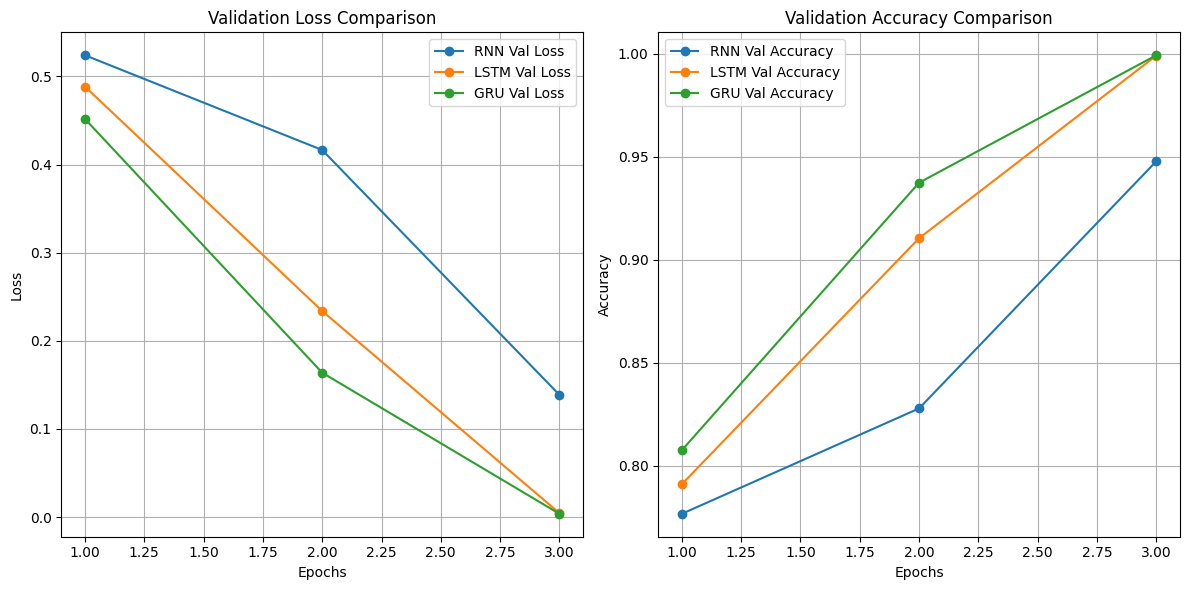

In [53]:
# Создание графиков для потерь
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, N_EPOCHS + 1), val_losses_rnn, label='RNN Val Loss', marker='o')
plt.plot(range(1, N_EPOCHS + 1), val_losses_lstm, label='LSTM Val Loss', marker='o')
plt.plot(range(1, N_EPOCHS + 1), val_losses_gru, label='GRU Val Loss', marker='o')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, N_EPOCHS + 1), val_accuracies_rnn, label='RNN Val Accuracy', marker='o')
plt.plot(range(1, N_EPOCHS + 1), val_accuracies_lstm, label='LSTM Val Accuracy', marker='o')
plt.plot(range(1, N_EPOCHS + 1), val_accuracies_gru, label='GRU Val Accuracy', marker='o')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()


### Резюме:

Сравнение моделей RNN, LSTM и GRU показывает преимущества использования LSTM и GRU для задач с последовательными данными. Эти модели обеспечивают лучшую производительность по всем метрикам. 